In [107]:
#!pip install torch torchaudio librosa numpy matplotlib scikit-learn


In [108]:
import os
import random
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Reproducibilidad básica
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device (GPU si existe)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Audio
SR = 22050
DURATION = 5.0
SAMPLES = int(SR * DURATION)

# Mel-spectrogram
N_MELS = 128
HOP_LENGTH = 512
MAX_FRAMES = 216  # para 5 segundos aprox

# Dataset
AUDIO_DIR = ".ESC/audio/audio"
MAX_FILES = 500   # puedes subirlo luego

# Entrenamiento
BATCH_SIZE = 32
EPOCHS = 25
LR = 5e-4


Using device: cuda


In [110]:
def load_audio(path):
    audio, _ = librosa.load(path, sr=SR)
    if len(audio) < SAMPLES:
        audio = np.pad(audio, (0, SAMPLES - len(audio)))
    else:
        audio = audio[:SAMPLES]
    return audio

In [111]:
def add_white_noise(audio, snr_db=5):
    signal_power = np.mean(audio ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), audio.shape)
    return audio + noise


In [112]:
def add_background_noise(audio, noise_audio, alpha=0.5):
    noise_audio = noise_audio[:len(audio)]
    return (1 - alpha) * audio + alpha * noise_audio


In [113]:
def apply_clipping(audio, threshold=0.45):
    return np.clip(audio, -threshold, threshold)


In [114]:
def apply_compression(audio, bits=4):
    max_val = np.max(np.abs(audio))
    audio_norm = audio / max_val
    levels = 2 ** bits
    audio_quant = np.round(audio_norm * levels) / levels
    return audio_quant * max_val


In [115]:
def audio_to_mel(audio):
    mel = librosa.feature.melspectrogram(
        y=audio,
        sr=SR,
        n_mels=N_MELS,
        hop_length=HOP_LENGTH
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db


In [116]:
def fix_mel_length(mel):
    if mel.shape[1] < MAX_FRAMES:
        pad = MAX_FRAMES - mel.shape[1]
        mel = np.pad(mel, ((0, 0), (0, pad)))
    else:
        mel = mel[:, :MAX_FRAMES]
    return mel


In [117]:
LABELS = {
    "white_noise": 0,
    "background_noise": 1,
    "clipping": 2,
    "compression": 3
}


In [118]:
audio_files = [
    os.path.join(AUDIO_DIR, f)
    for f in os.listdir(AUDIO_DIR)
    if f.endswith(".wav")
][:MAX_FILES]


In [119]:
X, y = [], []

for i, path in enumerate(audio_files):
    clean = load_audio(path)

    noise_path = random.choice(audio_files)
    noise_audio = load_audio(noise_path)

    versions = {
        "white_noise": add_white_noise(clean),
        "background_noise": add_background_noise(clean, noise_audio),
        "clipping": apply_clipping(clean),
        "compression": apply_compression(clean)
    }

    for label, audio in versions.items():

        # NORMALIZACIÓN
        if label != "clipping":
            audio = audio / (np.max(np.abs(audio)) + 1e-8)

        mel = audio_to_mel(audio)
        mel = fix_mel_length(mel)

        # NORMALIZACIÓN DEL ESPECTROGRAMA
        mel = (mel - mel.mean()) / (mel.std() + 1e-8)

        X.append(mel)
        y.append(LABELS[label])


In [120]:
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)


In [121]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y


In [122]:
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [123]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(128 * 16 * 27, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)


In [124]:
model = AudioCNN(num_classes=len(LABELS)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y_batch in train_loader:
        x = x.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")


Epoch 1/25 - Loss: 47.3307
Epoch 2/25 - Loss: 29.4748
Epoch 3/25 - Loss: 26.0824
Epoch 4/25 - Loss: 24.2008
Epoch 5/25 - Loss: 22.7273
Epoch 6/25 - Loss: 19.1001
Epoch 7/25 - Loss: 18.0178
Epoch 8/25 - Loss: 16.9191
Epoch 9/25 - Loss: 14.9915
Epoch 10/25 - Loss: 16.1309
Epoch 11/25 - Loss: 12.9737
Epoch 12/25 - Loss: 12.4449
Epoch 13/25 - Loss: 11.2429
Epoch 14/25 - Loss: 10.0216
Epoch 15/25 - Loss: 9.3304
Epoch 16/25 - Loss: 8.7342
Epoch 17/25 - Loss: 7.9306
Epoch 18/25 - Loss: 7.1071
Epoch 19/25 - Loss: 7.1224
Epoch 20/25 - Loss: 6.9941
Epoch 21/25 - Loss: 6.7281
Epoch 22/25 - Loss: 5.6486
Epoch 23/25 - Loss: 5.0231
Epoch 24/25 - Loss: 4.9209
Epoch 25/25 - Loss: 5.7104


In [125]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y_batch in test_loader:
        x = x.to(DEVICE)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()

        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       0.60      0.78      0.68       100
           2       0.57      0.31      0.40       100
           3       0.81      0.92      0.86       100

    accuracy                           0.75       400
   macro avg       0.74      0.75      0.73       400
weighted avg       0.74      0.75      0.73       400



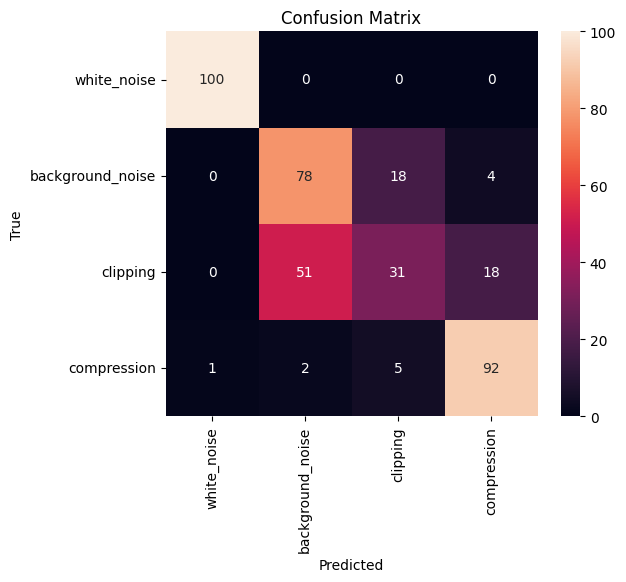

In [126]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=LABELS.keys(),
            yticklabels=LABELS.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
